In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
from matplotlib import cm, mlab
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image

# 1

## a

In [ ]:
Image(filename="1a.png")

## b

In [ ]:
housing_data = scipy.io.loadmat("data/housing_data.mat")
raw_x_train = pd.DataFrame(housing_data['Xtrain'])
raw_y_train = pd.DataFrame(housing_data['Ytrain'])
raw_x_validate = pd.DataFrame(housing_data['Xvalidate'])
raw_y_validate = pd.DataFrame(housing_data['Yvalidate'])
print(raw_x_train.shape, raw_y_train.shape)
print( raw_x_validate.shape,raw_y_validate.shape)

In [ ]:
raw_x_train[9] = 1 # bias term or normalize :)
raw_x_validate[9] = 1
print(raw_x_train.shape, raw_y_train.shape)
print(raw_x_validate.shape, raw_y_validate.shape)
X_train = raw_x_train.values
y_train = raw_y_train.values
X_val = raw_x_validate.values
y_val = raw_y_validate.values

In [ ]:
def kfolds(X, y, n_folds):
    chunk_size = len(X)/n_folds
    chunks = [(chunk_size * x, chunk_size * (x+1)) for x in range(n_folds)]
    for start, end in chunks:
        sub_X = np.concatenate([X[:start], X[end:]])
        sub_y = np.concatenate([y[:start], y[end:]])
        other_X = X[start:end]
        other_y = y[start:end]
        yield sub_X, sub_y, other_X, other_y
        
def get_results(y_hat, y_val):
    rss = np.sum((y_val - y_hat) ** 2)
    tss = np.sum((y_val - np.mean(y_val)) ** 2)
    r_sqrd = 1 - (rss/tss)
    return rss, r_sqrd

def train_model(X, y, lamb):
    lamby = lamb * np.ones(len(X.T))
    front = np.dot(X.T, X)
    invert_me = front + lamby
    inv = np.linalg.inv(invert_me)
    return inv.dot(np.dot(X.T, y))

# w = np.dot(np.dot(np.linalg.inv(np.dot(X_train.T, X_train)), X_train.T), y_train)
# print(w.reshape((9,)))
# y_hat = np.dot(X_val,w)

In [ ]:
all_scores = {}
for lamb in [10e-1, 10e-2, 10e-3, 10e-4, 10e-5, 10e-6, 10e-7, 10e-8]:
    print("Lambda Value: ", lamb)
    scores = []
    for count, (X_1, y_1, X_2, y_2) in enumerate(kfolds(X_train, y_train, 10)):
        w = train_model(X_1, y_1, lamb)
        y_hat = np.dot(X_2, w)
        rss, r_sqrd = get_results(y_hat, y_2)
        scores.append(rss)
    print("Mean RSS of: %.2f and variance of %.2f" % (np.array(scores).mean(), np.array(scores).var()))
    all_scores[lamb] = scores

In [ ]:
pd.DataFrame(all_scores).mean(axis=0)

In [ ]:
best_lambda = pd.DataFrame(all_scores).mean(axis=0).idxmin()
print(best_lambda)
print("Best Lambda Value:", best_lambda)

In [ ]:
pd.DataFrame(all_scores).min(axis=0)

In [ ]:
pd.DataFrame(all_scores).min(axis=0).plot(kind='bar')

In [ ]:
ws = train_model(X_train, y_train, best_lambda)
y_hat = np.dot(X_val, ws)
pd.DataFrame(ws[:8]).plot() # removed bias
rss = np.sum((y_val - y_hat) ** 2)
tss = np.sum((y_val - np.mean(y_val)) ** 2)
r_sqrd = 1 - (rss/tss)
print("RSS: %i" % rss)
print("R^2: %.3f" % r_sqrd)
print("Range of y Hat Values => Min: %i Max: %i" %(min(y_hat), max(y_hat)))
print("Range of True Y Values => Min: %i Max: %i" %(min(y_val), max(y_val)))

Old Values:

RSS: 5794953797676

R^2: 0.643

Range of y Hat Values => Min: -56562 Max: 710798

Range of True Y Values => Min: 28300 Max: 500001


## HW3 Plot
We can see that they're roughly the same except for the fact that the newer graph is just a but more squished in - which is what we would expect from using shrinkage.

In [ ]:
Image(filename='hw3_plot.png') 

error terms.

In [ ]:
pd.Series((y_val - y_hat).reshape((1200,))).plot(kind='hist', bins=20)

# 2

## 2.a 

$$1/36$$


## 2.b

$$ p  + (1 - p) = 1 $$
$$ p^* = 1 - (1 - p)^3 $$
$$ p^* = 1 - (35/36)^3 $$
$$ p^* = .081039952 $$

## 2.c
Here's what we need to calculate.

$$ P(x \leq 203) = (1000 choose 203) 0.5 ^{203} (1-0.5)^{1000-203} $$

However this is obviously inefficient computationally, so we've got to approximate the binomial with the normal distribution with the continuity correction.


In [ ]:
n = 1000
p = 0.5
mu = n * p
sigma = np.sqrt(1000 * 0.5 * (1-0.5))
z = (203.5 - mu)/sigma
print(z)

The $ p < 0.00001 $ making it a simple matter to reject the null hypothesis[that there is no difference between the errors of our algorithm and our competitors].



## 2.d 
With more trials, we are more likely to get a 0.05 p-value or lower. Therefore we cannot reject the null hypothesis without adjusting our critical value accordingly.

## 2.e
Just like with our dice roll above, with repeated trails we are changing the probabilities. We're effectively rolling the dice several times and we've got to correct for that.

$$ p_{significant} + p_{not-significant} = 1$$

$$p_s = 1 - (1 - p_s)^m$$

Just like above, as $m$ increases $(1-p_s)$ will approach 0 and $p_s$ will approach 1. We can correct for this by  multiplying our returned p-value by m trials. As m increases to infinity, this will cause p_s to now approach zero, eliminating any possible chance of false discovery rate (and consequentially positive rates). That is to say, the Bonferroni correction prevents false positives, but doesn't prevent false negatives. This is why it's often called too conservative.


## 2.f

Although we get a small value, due to the Bonferroni Correction, this gene is not significant because we get a p-value of 5. A p-value of 5 shows us that the Bonferroni correction acts as an upper bound on our probability. Because the corrected p value is so high, we can safely reject that this variable is significant.

# 3

In [ ]:
Image("3.png")

## 3.c (part 2)

A data set that would reflect this would be where a companies best customers are either young and male or old and female, but not both. This dataset is not linearly separable in the conventional space by a method like a perceptron. However this might be linearly seperable in some phi-space, which is why we might approach this problem with a kernel.

# 4

## 4.a

In [ ]:
delta = 0.025
x = np.arange(-4.0, 7.0, delta)
y = np.arange(-4.0, 5.0, delta)
X, Y = np.meshgrid(x, y)
Z = mlab.bivariate_normal(X, Y, sigmax=2, sigmay=1.0, mux=1, muy=1, sigmaxy=0.0)
fig = plt.figure()
ax = fig.gca(projection='3d')
CS = plt.contour(X, Y, Z)
plt.show()
fig = plt.figure()
CS = plt.contour(X, Y, Z)
plt.show()

## 4.b

In [ ]:
delta = 0.025
x = np.arange(-10.0, 7.0, delta)
y = np.arange(-4.0, 8.0, delta)
X, Y = np.meshgrid(x, y)
Z = mlab.bivariate_normal(X, Y, sigmax=3, sigmay=2.0, mux=-1, muy=2, sigmaxy=1.0)
fig = plt.figure()
ax = fig.gca(projection='3d')
CS = plt.contour(X, Y, Z)
plt.show()
fig = plt.figure()
CS = plt.contour(X, Y, Z)
plt.show()

## 4.c

In [ ]:
delta = 0.025
x = np.arange(-10.0, 7.0, delta)
y = np.arange(-10.0, 10.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = mlab.bivariate_normal(X, Y, sigmax=1, sigmay=2.0, mux=0, muy=2, sigmaxy=1.0)
Z2 = mlab.bivariate_normal(X, Y, sigmax=1, sigmay=2.0, mux=2, muy=0, sigmaxy=1.0)
Z = Z1 - Z2
fig = plt.figure()
ax = fig.gca(projection='3d')
CS = plt.contour(X, Y, Z)
plt.show()
fig = plt.figure()
CS = plt.contour(X, Y, Z)
plt.show()

## 4.d

In [ ]:
delta = 0.025
x = np.arange(-5.0, 7.0, delta)
y = np.arange(-5.0, 10.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = mlab.bivariate_normal(X, Y, sigmax=1, sigmay=2.0, mux=0, muy=2, sigmaxy=1.0)
Z2 = mlab.bivariate_normal(X, Y, sigmax=3, sigmay=2.0, mux=2, muy=0, sigmaxy=1.0)
Z = Z1 - Z2
fig = plt.figure()
ax = fig.gca(projection='3d')
CS = plt.contour(X, Y, Z)
plt.show()
fig = plt.figure()
CS = plt.contour(X, Y, Z)
plt.show()

## 4.e

In [ ]:
delta = 0.025
x = np.arange(-5.0, 7.0, delta)
y = np.arange(-5.0, 10.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = mlab.bivariate_normal(X, Y, sigmax=1, sigmay=2.0, mux=1, muy=1, sigmaxy=0.0)
Z2 = mlab.bivariate_normal(X, Y, sigmax=2, sigmay=2.0, mux=-1, muy=-1, sigmaxy=1.0)
Z = Z1 - Z2
fig = plt.figure()
ax = fig.gca(projection='3d')
CS = plt.contour(X, Y, Z)
plt.show()
fig = plt.figure()
CS = plt.contour(X, Y, Z)
plt.show()

# 5

## 5.a

In [ ]:
N = 100
np.random.seed(20)
x1s = np.random.normal(3,np.sqrt(9), 100)
x2s = 1/2*x1s + np.random.normal(4, np.sqrt(4), 100)

print("Mean X_1:", np.mean(x1s))
print("Mean X_2:", np.mean(x2s))
df = pd.DataFrame({"x1": x1s, "x2": x2s})

## 5.b

In [ ]:
df.cov()

## 5.c

In [ ]:
eig_vals, eig_vecs = np.linalg.eig(df.cov().values) # quiver functions to get arrows
print(eig_vecs)
print(eig_vals)

## 5.d

In [ ]:
hw = 15
df.plot(x="x1", y='x2', kind='scatter', ylim=(-hw,hw),xlim=(-hw,hw))
x, y = df.x1.mean(), df.x2.mean()
u1, v1 = eig_vecs[:,0] * eig_vals[0]
u2, v2 = eig_vecs[:,1] * eig_vals[1]
plt.quiver(x, y, u1, v1, angles='xy', scale_units='xy',scale=1,color='r')
plt.quiver(x, y, u2, v2, angles='xy', scale_units='xy',scale=1,color='g')

## 5.e

# 6 

# 7

In [2]:
from scipy.stats import multivariate_normal

dig_train = scipy.io.loadmat("data/train.mat")
dig_X = dig_train['train_images'].T.reshape((60000,784))
dig_y = dig_train['train_labels'].reshape(60000,)
shuff = np.arange(len(dig_y))
np.random.shuffle(shuff)
dig_X_train = dig_X[shuff]/255
dig_y_train = dig_y[shuff]
dig_val_X = dig_X_train[50000:]
dig_val_y = dig_y_train[50000:]
dig_X_train = dig_X_train[:50000]
dig_y_train = dig_y_train[:50000]


dig_test = scipy.io.loadmat("data/test.mat")
dig_X_test = dig_test['test_images']
dig_y_test = dig_test['test_labels'].reshape((10000))

print(dig_X_train.shape,dig_y_train.shape, dig_X_test.shape, dig_y_test.shape) # make sure our shapes are good

(50000, 784) (50000,) (10000, 784) (10000,)


## 7.a

The maximum likelihood estimates for the mean and the covariance matrix of a Gaussian

In [ ]:
# optional manipulations
# dig_X_train = dig_X_train / np.linalg.norm(dig_X_train, 2)
# dig_X_test = dig_X_test / np.linalg.norm(dig_X_test, 2)

## 7.b

You can compute priors by seeing the density of a given value in the training set.

In [3]:
priors = pd.Series(dig_y_train).value_counts() / len(dig_y_train)
priors

1    0.11196
7    0.10396
3    0.10236
9    0.10004
6    0.09924
2    0.09920
0    0.09782
8    0.09746
4    0.09696
5    0.09100
dtype: float64

In [4]:
means = {}
for num in range(10):
    means[num] = dig_X_train[dig_y_train == num].mean(axis=0)

## 7.c

In [ ]:
import seaborn as sns

In [ ]:
sns.heatmap(np.cov(X[y == 0].T))

These visualizations show how the various pixels covary with one another. We can see that the pixels in the middle are fairly consistent, but since we're looking at a zero. They tend to vary together along the edges of the image.

## 7.d

### i

In [7]:
def get_mu_sigma(X_, y_, labels, alpha):
    mus = []
    for label in labels:
        vals = X_[y_ == label]
        mus.append(np.mean(vals, axis=0))
    sigma = np.cov(X_.T)
    np.fill_diagonal(sigma, alpha + np.diag(sigma))
    return mus, sigma

def train_gaussian(mus, sigma, labels):
    classes = []
    for label in labels:
        model = multivariate_normal(mus[label], sigma)
        classes.append((label, model))
    return classes

def classify_gaussian(labels_models, X):
    outputs = []
    for label, model in labels_models:
        outputs.append(model.logpdf(X))
    return np.array(outputs).argmax(axis=0)

def test_gaussian(labels_models, X, y):
    y_hat = classify_gaussian(labels_models, X)
    return np.sum(y != y_hat) / len(y)

def run_mv(X_, y_, test_X, test_Y, alpha):
    error_rates = []
    test_error_rates = []
    trial_amounts = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
    for x in trial_amounts:
        Xs = X_[:x]
        Ys = y_[:x]
        mus, sigma = get_mu_sigma(Xs, Ys, range(10), alpha)
        classes = train_gaussian(mus, sigma, range(10))
        print("Trained on ", len(Xs))
        error_rate = test_gaussian(classes, X_, y_)
        test_error_rate = test_gaussian(classes, test_X, test_Y)
        print(error_rate,test_error_rate)
        error_rates.append(error_rate)
        test_error_rates.append(test_error_rate)
    return {"train_error":error_rates, 
            "vaidation_error": test_error_rates, 
            "train_amount": trial_amounts}

In [5]:
errors = run_mv(dig_X_train, dig_y_train, dig_val_X, dig_val_y, 0.001)

Trained on  100
0.4156 0.4108
Trained on  200
0.44724 0.4418
Trained on  500
0.42746 0.434
Trained on  1000
0.32954 0.3396
Trained on  2000
0.2586 0.2697
Trained on  5000
0.21236 0.2204
Trained on  10000
0.19344 0.199
Trained on  30000
0.1812 0.1895
Trained on  50000
0.18014 0.1868


,train_amount,train_error,vaidation_error
0,100,0.41560,0.4108
1,200,0.44724,0.4418
2,500,0.42746,0.4340
3,1000,0.32954,0.3396
4,2000,0.25860,0.2697
5,5000,0.21236,0.2204
6,10000,0.19344,0.1990
7,30000,0.18120,0.1895
8,50000,0.18014,0.1868


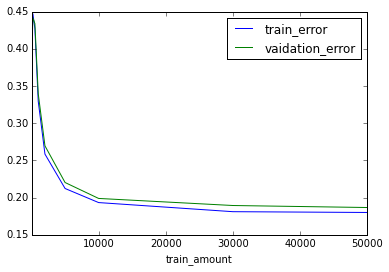

In [6]:
pd.DataFrame(errors).plot(x='train_amount')
pd.DataFrame(errors)

The form of the decision boundary is linear because we assume that each grouping/class/cluster has the same variance. This is because they all occupy the same fundamental amount space in our X-space, we're basically drawing linear boundaries in between each class and all the others.

### ii

In [8]:
def get_mu_sigma2(X_, y_, labels, alpha):
    mus = []
    sigmas = []
    for label in labels:
        vals = X_[y_ == label]
        mus.append(np.mean(vals, axis=0))
        sigma = np.cov(vals.T)
        np.fill_diagonal(sigma, alpha + np.diag(sigma))
        sigmas.append(sigma)
    return mus, sigmas

def train_gaussian2(mus, sigmas, labels):
    classes = []
    for label in labels:
        model = multivariate_normal(mus[label], sigmas[label])
        classes.append((label, model))
    return classes

def run_mv2(X_, y_, test_X, test_Y, alpha):
    error_rates = []
    test_error_rates = []
    trial_amounts = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
    for x in trial_amounts:
        Xs = X_[:x]
        Ys = y_[:x]
        mus, sigmas = get_mu_sigma2(Xs, Ys, range(10), alpha)
        classes = train_gaussian2(mus, sigmas, range(10))
        print("Trained on ", len(Xs))
        error_rate = test_gaussian(classes, X_, y_)
        test_error_rate = test_gaussian(classes, test_X, test_Y)
        print(error_rate,test_error_rate)
        error_rates.append(error_rate)
        test_error_rates.append(test_error_rate)
    return {"train_error":error_rates, 
            "test_error": test_error_rates, 
            "train_amount": trial_amounts}

In [9]:
errors = run_mv2(dig_X_train, dig_y_train, dig_val_X, dig_val_y, 0.001)

Trained on  100
0.31134 0.3085
Trained on  200
0.21584 0.2124
Trained on  500
0.1605 0.1635
Trained on  1000
0.11532 0.1193
Trained on  2000
0.11732 0.1251
Trained on  5000
0.1112 0.1259
Trained on  10000
0.0984 0.1257
Trained on  30000
0.08536 0.1252
Trained on  50000
0.0829 0.1233


,test_error,train_amount,train_error
0,0.3085,100,0.31134
1,0.2124,200,0.21584
2,0.1635,500,0.16050
3,0.1193,1000,0.11532
4,0.1251,2000,0.11732
5,0.1259,5000,0.11120
6,0.1257,10000,0.09840
7,0.1252,30000,0.08536
8,0.1233,50000,0.08290


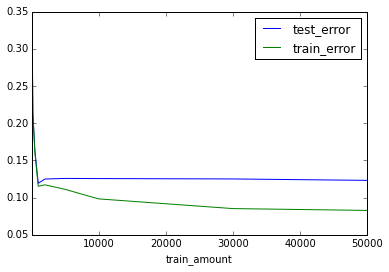

In [10]:
pd.DataFrame(errors).plot(x='train_amount')
pd.DataFrame(errors)

This is a non-linear decision boundary because we vary our covariance matrix with the class. This makes it non-linear because th progressions are not constant and can interweave more than they could with a constant covariance matrix.

### iii

The difference between these two is whether or not we assume they fundamentally share the same covariance matrix(i) or if they have their own individual covariance matrices(ii). When we assume that each class has its own covariance matrix we can see that some samples of our data seem to be better representations than others, for example the 500 and 1000 sets have a very small training and test error. This means that they generalize better than the 5000 sample that we pulled.

### iv

In [11]:
dig_kaggle_X = scipy.io.loadmat("kaggle/test.mat")['test_images']/255
dig_kaggle_X.shape

(10000, 784)

In [15]:
mus, sigma = get_mu_sigma(dig_X_train, dig_y_train, range(10), 0.001)
classes = train_gaussian(mus, sigma, range(10))
y_hat = classify_gaussian(classes, dig_kaggle_X)

In [16]:
yh = pd.DataFrame({"Category":y_hat, "Id":range(1,1+len(y_hat))})
yh.to_csv("out.csv",index=False)

## 7.e

In [53]:
from scipy.stats import multivariate_normal

spam_train = scipy.io.loadmat("data/spam_data.mat")
spam_X = spam_train['training_data']
spam_y = spam_train['training_labels'].T.reshape((5172,))
print(spam_X.shape, spam_y.shape)
shuff = np.arange(len(spam_y))
np.random.shuffle(shuff)
spam_X_train = spam_X[shuff]
spam_y_train = spam_y[shuff]
train_test_amount = 4000
spam_val_X = spam_X_train[train_test_amount:]
spam_val_y = spam_y_train[train_test_amount:]
spam_X_train = spam_X_train[:train_test_amount]
spam_y_train = spam_y_train[:train_test_amount]

spam_X_test = spam_train['test_data']

print(spam_X_train.shape,spam_y_train.shape, spam_val_X.shape) # make sure our shapes are good

(5172, 32) (5172,)
(4000, 32) (4000,) (1172, 32)


In [60]:
def run_mv_spam(X_, y_, test_X, test_Y, alpha):
    error_rates = []
    test_error_rates = []
    trial_amounts = [100, 200, 500, 1000, 2000, 4000]
    for x in trial_amounts:
        Xs = X_[:x]
        Ys = y_[:x]
        mus, sigma = get_mu_sigma(Xs, Ys, range(2), alpha)
        classes = train_gaussian(mus, sigma, range(2))
        print("Trained on ", len(Xs))
        error_rate = test_gaussian(classes, X_, y_)
        test_error_rate = test_gaussian(classes, test_X, test_Y)
        print(error_rate,test_error_rate)
        error_rates.append(error_rate)
        test_error_rates.append(test_error_rate)
    return {"train_error":error_rates, 
            "vaidation_error": test_error_rates, 
            "train_amount": trial_amounts}

def run_mv2_spam(X_, y_, test_X, test_Y, alpha):
    error_rates = []
    test_error_rates = []
    trial_amounts = [100, 200, 500, 1000, 2000, 4000]
    for x in trial_amounts:
        Xs = X_[:x]
        Ys = y_[:x]
        mus, sigmas = get_mu_sigma2(Xs, Ys, range(2), alpha)
        classes = train_gaussian2(mus, sigmas, range(2))
        print("Trained on ", len(Xs))
        error_rate = test_gaussian(classes, X_, y_)
        test_error_rate = test_gaussian(classes, test_X, test_Y)
        print(error_rate,test_error_rate)
        error_rates.append(error_rate)
        test_error_rates.append(test_error_rate)
    return {"train_error":error_rates, 
            "test_error": test_error_rates, 
            "train_amount": trial_amounts}

Trained on  100
0.247 0.244880546075
Trained on  200
0.21525 0.215017064846
Trained on  500
0.213 0.212457337884
Trained on  1000
0.19675 0.189419795222
Trained on  2000
0.19725 0.189419795222
Trained on  4000
0.19325 0.189419795222


,train_amount,train_error,vaidation_error
0,100,0.24700,0.244881
1,200,0.21525,0.215017
2,500,0.21300,0.212457
3,1000,0.19675,0.189420
4,2000,0.19725,0.189420
5,4000,0.19325,0.189420


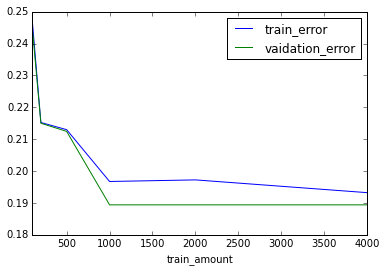

In [61]:
errors = run_mv_spam(spam_X_train, spam_y_train, spam_val_X, spam_val_y, 0.001)
pd.DataFrame(errors).plot(x='train_amount')
pd.DataFrame(errors)

Trained on  100
0.264 0.255972696246
Trained on  200
0.27975 0.285836177474
Trained on  500
0.2115 0.20819112628
Trained on  1000
0.2075 0.212457337884
Trained on  2000
0.206 0.210750853242
Trained on  4000
0.206 0.20819112628


,test_error,train_amount,train_error
0,0.255973,100,0.26400
1,0.285836,200,0.27975
2,0.208191,500,0.21150
3,0.212457,1000,0.20750
4,0.210751,2000,0.20600
5,0.208191,4000,0.20600


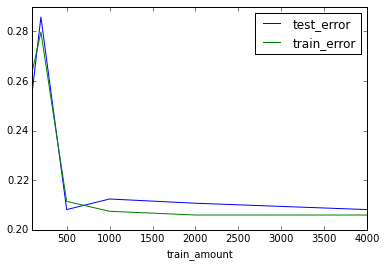

In [62]:
errors = run_mv2_spam(spam_X_train, spam_y_train, spam_val_X, spam_val_y, 0.001)
pd.DataFrame(errors).plot(x='train_amount')
pd.DataFrame(errors)

In [64]:
mus, sigma = get_mu_sigma2(spam_X_train, spam_y_train, range(2), 0.001)
classes = train_gaussian2(mus, sigma, range(2))
y_hat = classify_gaussian(classes, spam_X_test)


In [65]:
yh = pd.DataFrame({"Category":y_hat, "Id":range(1,1+len(y_hat))})
yh.to_csv("out_spam2.csv",index=False)